# **２．実際の地震同記録を用いた1自由度系の応答計算**
### **2.1　1自由度系の加速度・速度・変位応答（固有周期1.0秒の場合）**

In [2]:
!pip install japanize_matplotlib

解析開始... (Tn=1.0s, h=0.05, dt=0.02s)
解析完了。
結果を response_Tn1.0_h0.05.csv に保存しました。


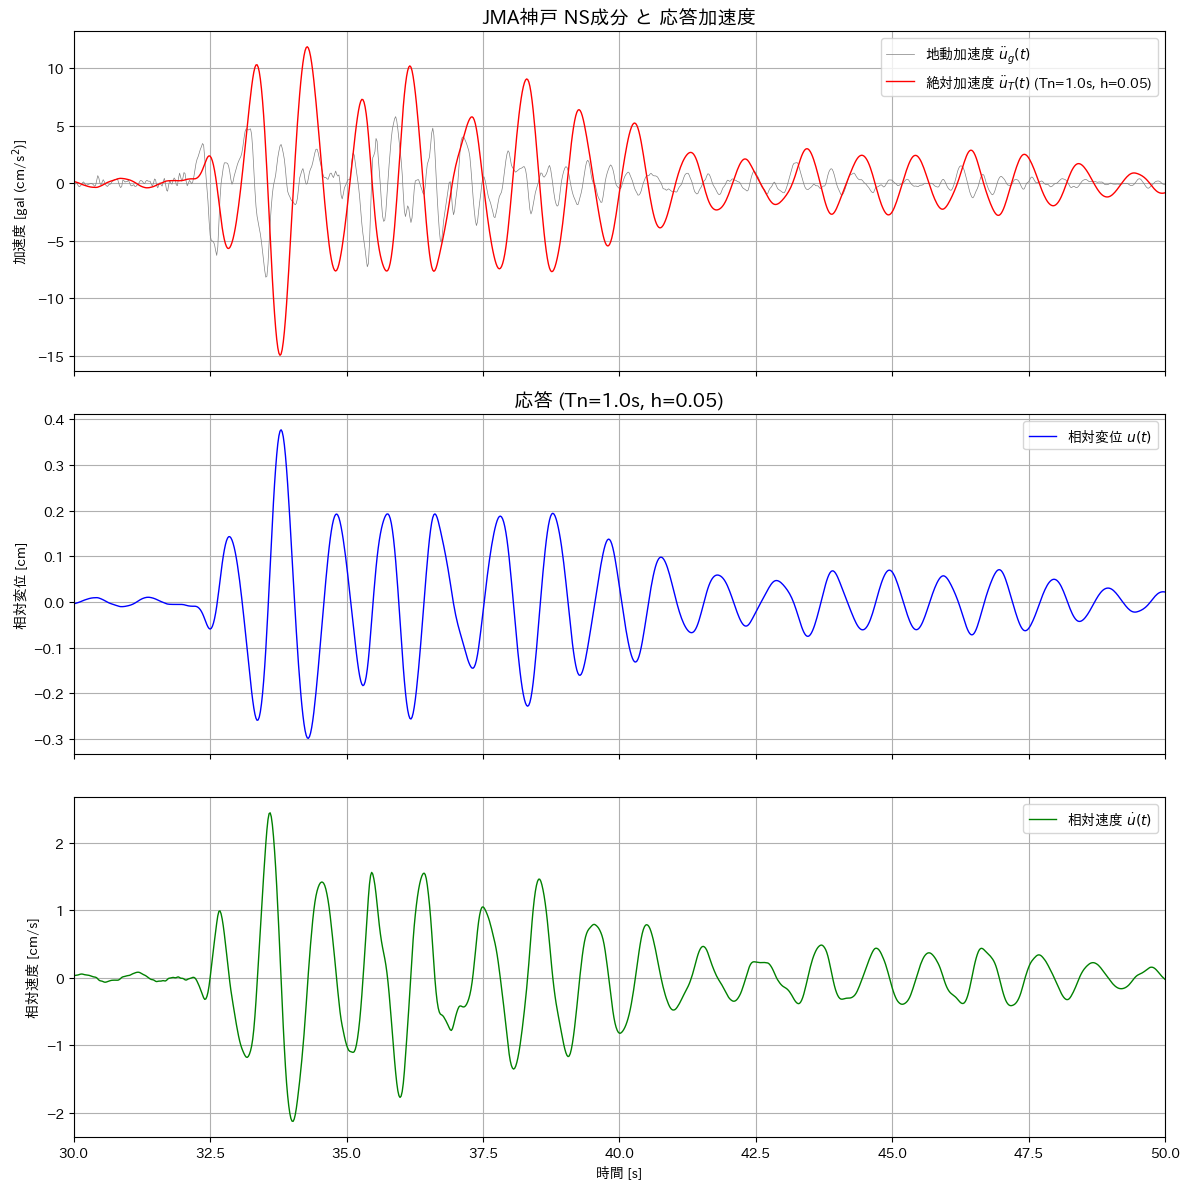

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# -----------------------------------------------------------------
# 1. 地震波データの読み込み関数
# -----------------------------------------------------------------
def load_jma_kobe_data(filename="1995兵庫県南部地震.csv", component='NS'):
    """
    JMA神戸波のCSVファイルを読み込む
    """

    # サンプリングレート(Hz)の情報をヘッダー（4行目）から取得
    with open(filename, 'r', encoding='shift_jis') as f:
        for i, line in enumerate(f):
            if i == 3:  # 4行目 (SAMPLING RATE)
                rate_str = line.split(',')[0].split('=')[1]
                dt = 1.0 / float(rate_str.replace('Hz', '').strip())
                break

    # データ部（8行目以降）をpandasで読み込む
    data = pd.read_csv(
        filename,
        skiprows=7,  # 最初の7行をスキップ (8行目からデータ)
        header=None, # データにヘッダー行は無い
        usecols=[0, 1, 2], # 最初の3列（NS, EW, UD）のみ使用
        names=['NS', 'EW', 'UD'], # 列名を付ける
        encoding='shift_jis'
    )

    # 欠損値（,,）などがあれば0で埋める
    data = data.fillna(0)

    # 指定された成分のデータを，単位変換して，Numpy配列(float)として返す
    ag = data[component].to_numpy(dtype=float) /100

    return ag, dt

# -----------------------------------------------------------------
# 2. Newmark-β法 汎用ソルバー
# -----------------------------------------------------------------
def newmark_beta(m, c, k, p_force, dt, u0, v0, beta, gamma):
    """
    Newmark-β法（有効剛性法）の汎用ソルバー
    """
    n_steps = len(p_force)
    u = np.zeros(n_steps)
    v = np.zeros(n_steps)
    a = np.zeros(n_steps)

    u[0] = u0
    v[0] = v0
    a[0] = (p_force[0] - c * v[0] - k * u[0]) / m

    a0 = 1.0 / (beta * dt**2)
    a1 = gamma / (beta * dt)
    a2 = 1.0 / (beta * dt)
    a3 = 1.0 / (2.0 * beta) - 1.0
    a4 = gamma / beta - 1.0
    a5 = (dt / 2.0) * (gamma / beta - 2.0)
    a6 = dt * (1.0 - gamma)
    a7 = gamma * dt

    K_hat = k + a0 * m + a1 * c

    for i in range(n_steps - 1):
        P_hat = p_force[i+1] + m * (a0*u[i] + a2*v[i] + a3*a[i]) \
                               + c * (a1*u[i] + a4*v[i] + a5*a[i])

        u[i+1] = P_hat / K_hat
        a[i+1] = a0 * (u[i+1] - u[i]) - a2 * v[i] - a3 * a[i]
        v[i+1] = v[i] + a6 * a[i] + a7 * a[i+1]

    t = np.arange(0, n_steps * dt, dt)
    return t, u, v, a

# -----------------------------------------------------------------
# 3. メイン実行部
# -----------------------------------------------------------------
if __name__ == "__main__":

    # --- (A) 解析条件 ---
    Tn = 1.0     # [s] 固有周期
    h = 0.05     # [ ] 減衰比 (5%)

    # --- (B) 地震動データの読み込み ---
    try:
        ag, dt = load_jma_kobe_data(filename="1995兵庫県南部地震.csv", component='NS')
    except FileNotFoundError:
        print("エラー: '1995兵庫県南部地震.csv' が見つかりません。")
        exit()
    except Exception as e:
        print(f"CSVファイルの読み込み中にエラーが発生しました: {e}")
        exit()

    # --- (C) システムの物理パラメータ ---
    m = 1.0
    wn = 2.0 * np.pi / Tn
    k = wn**2 * m
    c = 2.0 * h * wn * m

    # --- (D) Newmark-β法への入力 ---
    p_force = -m * ag
    u0 = 0.0
    v0 = 0.0
    beta = 1.0 / 4.0
    gamma = 1.0 / 2.0

    # --- (E) Newmark-β法による応答計算の実行 ---
    print(f"解析開始... (Tn={Tn}s, h={h}, dt={dt}s)")
    t, u, v, a = newmark_beta(m, c, k, p_force, dt, u0, v0, beta, gamma)
    print("解析完了。")

    # --- (E.1) 絶対加速度の計算 ---
    a_abs = ag + a  # 地動加速度 + 相対加速度

    # ★★★ ここから追加 ★★★
    # --- (E.5) 結果のファイル出力 ---

    # 出力ファイル名を指定
    output_filename = f'response_Tn{Tn}_h{h}.csv'

    # Pandas DataFrame に結果をまとめる
    results_df = pd.DataFrame({
        'Time (s)': t,
        'Input_Accel (m/s$^2$])': ag,
        'Response_Disp (m)': u,
        'Response_Vel (m/s)': v,
        'Response_Abs_Accel (gal)': a_abs  # 出力にも追加
    })

    # CSVファイルとして保存 (index=False で行番号を保存しない)
    results_df.to_csv(output_filename, index=False)
    print(f"結果を {output_filename} に保存しました。")
    # ★★★ ここまで追加 ★★★


# --- (F) 結果のグラフ描画 ---
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # ★★★ 修正点 ★★★
    # グラフ1: 入力（地動加速度）と応答（絶対加速度）

    # 凡例の文字列を .format() を使って安全に生成
    # LaTeX の \ddot{u} の {u} を {{u}} としてエスケープする
    label_abs = '絶対加速度 $\\ddot{{u}}_T(t)$ (Tn={}s, h={})'.format(Tn, h)

    ax1.plot(t, ag, 'gray', linewidth=0.5, label='地動加速度 $\\ddot{u}_g(t)$')
    # 絶対加速度を赤色で重ね書き
    ax1.plot(t, a_abs, 'red', linewidth=1.0, label=label_abs) # 修正した凡例を使用

    ax1.set_title(f"JMA神戸 NS成分 と 応答加速度", fontsize=14)
    ax1.set_ylabel('加速度 [gal (cm/s$^2$)]')
    ax1.grid(True)
    ax1.legend() # 凡例を表示
    # ★★★★★★★★★★★

    # グラフ2: 応答（相対変位）
    ax2.plot(t, u, 'blue', linewidth=1.0, label='相対変位 $u(t)$')
    ax2.set_title(f'応答 (Tn={Tn}s, h={h})', fontsize=14)
    ax2.set_ylabel('相対変位 [cm]')
    ax2.grid(True)
    ax2.legend()

    # グラフ3: 応答（相対速度）
    ax3.plot(t, v, 'green', linewidth=1.0, label='相対速度 $\\dot{u}(t)$')
    ax3.set_ylabel('相対速度 [cm/s]')
    ax3.set_xlabel('時間 [s]')
    ax3.grid(True)
    ax3.legend()

    # ★★★ 修正点 ★★★
    # x軸（時間軸）の表示範囲を30秒から60秒に設定
    ax1.set_xlim(30, 50)
    ax2.set_xlim(30, 50)
    ax3.set_xlim(30, 50)
    # ★★★★★★★★★★

    plt.tight_layout()
    plt.show()

### **2.2　加速度応答 vs. 変位応答の比較**

解析開始... (Tn=1.0s, h=0.05, dt=0.02s)
解析完了。
結果を response_Tn1.0_h0.05.csv に保存しました。


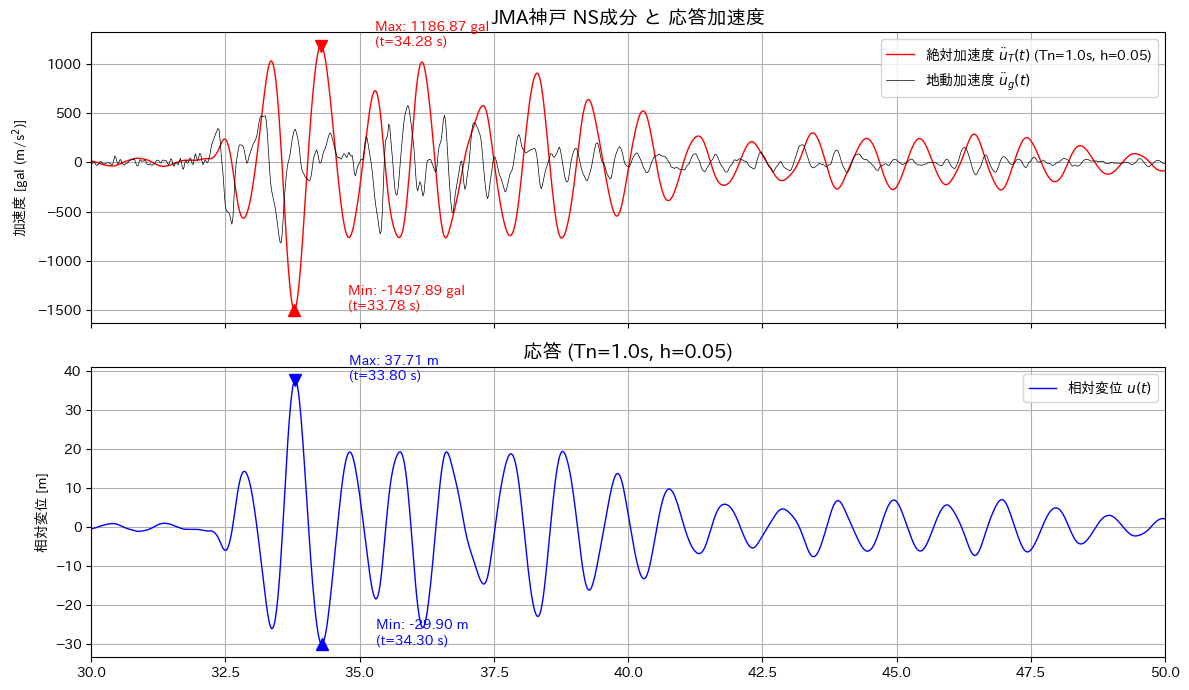

In [5]:
# (1. 読み込み関数 と 2. Newmark-β法ソルバー は変更なし)
# ... (load_jma_kobe_data と newmark_beta は省略) ...

# -----------------------------------------------------------------
# 3. メイン実行部
# -----------------------------------------------------------------
if __name__ == "__main__":

    # --- (A) 解析条件 ---
    Tn = 1.0     # [s] 固有周期
    h = 0.05     # [ ] 減衰比 (5%)

    # --- (B) 地震動データの読み込み ---
    try:
        ag, dt = load_jma_kobe_data(filename="1995兵庫県南部地震.csv", component='NS')
    except FileNotFoundError:
        print("エラー: '1995兵庫県南部地震.csv' が見つかりません。")
        exit()
    except Exception as e:
        print(f"CSVファイルの読み込み中にエラーが発生しました: {e}")
        exit()

    # --- (C) システムの物理パラメータ ---
    m = 1.0
    wn = 2.0 * np.pi / Tn
    k = wn**2 * m
    c = 2.0 * h * wn * m

    # --- (D) Newmark-β法への入力 ---
    p_force = -m * ag
    u0 = 0.0
    v0 = 0.0
    beta = 1.0 / 4.0
    gamma = 1.0 / 2.0

    # --- (E) Newmark-β法による応答計算の実行 ---
    print(f"解析開始... (Tn={Tn}s, h={h}, dt={dt}s)")
    t, u, v, a = newmark_beta(m, c, k, p_force, dt, u0, v0, beta, gamma)
    print("解析完了。")

    # --- (E.1) 絶対加速度の計算 ---
    a_abs = ag + a  # 地動加速度 + 相対加速度

    # --- (E.5) 結果のファイル出力 ---
    output_filename = f'response_Tn{Tn}_h{h}.csv'

    results_df = pd.DataFrame({
        'Time (s)': t,
        'Input_Accel (gal)': ag,
        'Response_Disp (cm)': u,
        'Response_Vel (cm/s)': v,
        'Response_Abs_Accel (gal)': a_abs  # 出力にも追加
    })

    results_df.to_csv(output_filename, index=False)
    print(f"結果を {output_filename} に保存しました。")

    # ★★★ ここから修正 ★★★
    # --- (F) 結果のグラフ描画 ---
    #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

    # --- (F.1) 最大値・最小値の計算 ---
    # (ax1) 絶対加速度
    max_a_abs = np.max(a_abs)
    idx_max_a_abs = np.argmax(a_abs)
    t_max_a_abs = t[idx_max_a_abs]

    min_a_abs = np.min(a_abs)
    idx_min_a_abs = np.argmin(a_abs)
    t_min_a_abs = t[idx_min_a_abs]

    # (ax2) 相対変位
    max_u = np.max(u)
    idx_max_u = np.argmax(u)
    t_max_u = t[idx_max_u]

    min_u = np.min(u)
    idx_min_u = np.argmin(u)
    t_min_u = t[idx_min_u]

    # (ax3) 相対速度
    max_v = np.max(v)
    idx_max_v = np.argmax(v)
    t_max_v = t[idx_max_v]

    min_v = np.min(v)
    idx_min_v = np.argmin(v)
    t_min_v = t[idx_min_v]

    # --- (F.2) グラフ1: 加速度 ---
    label_abs = '絶対加速度 $\\ddot{{u}}_T(t)$ (Tn={}s, h={})'.format(Tn, h)
    ax1.plot(t, a_abs, 'red', linewidth=1.0, label=label_abs)
    ax1.plot(t, ag, 'black', linewidth=0.5, label='地動加速度 $\\ddot{u}_g(t)$')

    # プロットと注釈 (ax1)
    ax1.plot(t_max_a_abs, max_a_abs, 'rv', markersize=8) # 最大値 (v: 赤)
    ax1.plot(t_min_a_abs, min_a_abs, 'r^', markersize=8) # 最小値 (^: 赤)
    ax1.annotate(f'Max: {max_a_abs:.2f} gal\n(t={t_max_a_abs:.2f} s)',
                 xy=(t_max_a_abs, max_a_abs), xytext=(t_max_a_abs + 1, max_a_abs - 1.5 ),
                 color='red', ha='left')
    ax1.annotate(f'Min: {min_a_abs:.2f} gal\n(t={t_min_a_abs:.2f} s)',
                 xy=(t_min_a_abs, min_a_abs), xytext=(t_min_a_abs + 1, min_a_abs + 0.5),
                 color='red', ha='left')

    ax1.set_title(f"JMA神戸 NS成分 と 応答加速度", fontsize=14)
    ax1.set_ylabel('加速度 [gal (m/s$^2$)]')
    ax1.grid(True)
    ax1.legend()

    # --- (F.3) グラフ2: 相対変位 ---
    ax2.plot(t, u, 'blue', linewidth=1.0, label='相対変位 $u(t)$')

    # プロットと注釈 (ax2)
    ax2.plot(t_max_u, max_u, 'bv', markersize=8) # 最大値 (v: 青)
    ax2.plot(t_min_u, min_u, 'b^', markersize=8) # 最小値 (^: 青)
    ax2.annotate(f'Max: {max_u:.2f} m\n(t={t_max_u:.2f} s)',
                 xy=(t_max_u, max_u), xytext=(t_max_u + 1, max_u - 0.05),
                 color='blue', ha='left')
    ax2.annotate(f'Min: {min_u:.2f} m\n(t={t_min_u:.2f} s)',
                 xy=(t_min_u, min_u), xytext=(t_min_u + 1, min_u - 0.02),
                 color='blue', ha='left')

    ax2.set_title(f'応答 (Tn={Tn}s, h={h})', fontsize=14)
    ax2.set_ylabel('相対変位 [m]')
    ax2.grid(True)
    ax2.legend()

    # --- (F.5) グラフ全体の設定 ---
    ax1.set_xlim(30, 50)
    ax2.set_xlim(30, 50)

    plt.tight_layout()
    plt.show()


### **2.3_a　短周期構造物の変位応答**

解析開始... (減衰比 h=0.05, 時間刻み dt=0.02s)
  - 計算中: Tn=0.3s (短周期) ...
全ケース解析完了。


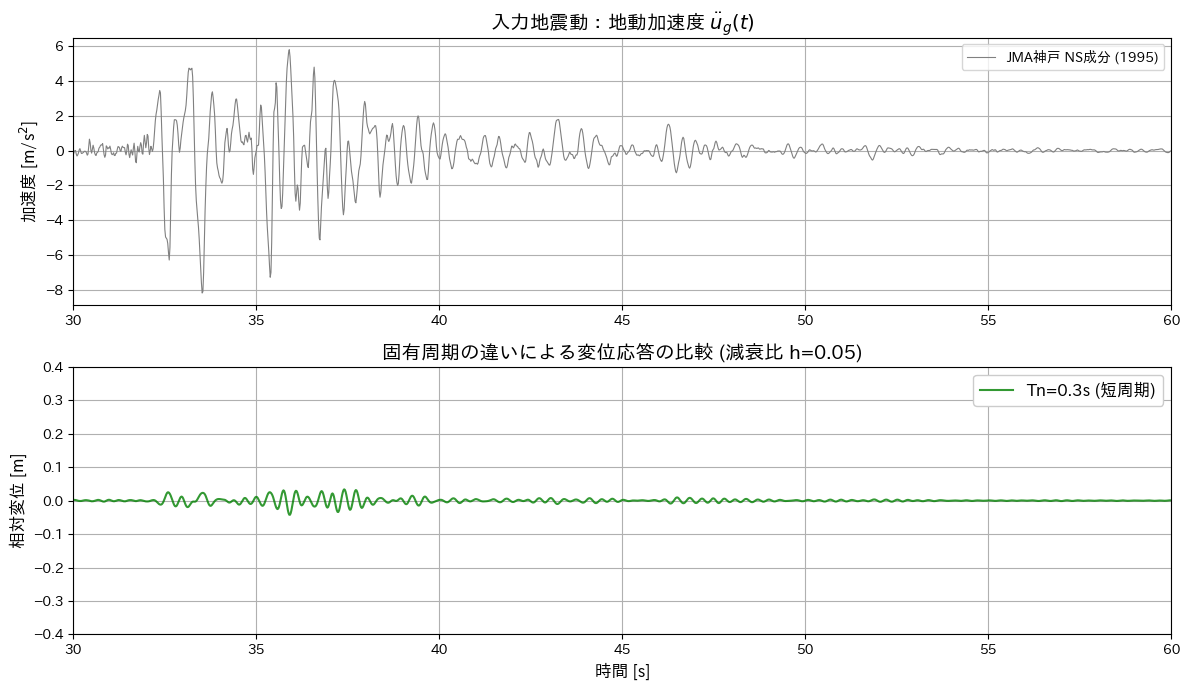

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# -----------------------------------------------------------------
# 1. 地震波データの読み込み関数 (変更なし)
# -----------------------------------------------------------------
def load_jma_kobe_data(filename="1995兵庫県南部地震.csv", component='NS'):
    """
    JMA神戸波のCSVファイルを読み込む
    """
    with open(filename, 'r', encoding='shift_jis') as f:
        for i, line in enumerate(f):
            if i == 3:  # 4行目 (SAMPLING RATE)
                rate_str = line.split(',')[0].split('=')[1]
                dt = 1.0 / float(rate_str.replace('Hz', '').strip())
                break

    data = pd.read_csv(
        filename,
        skiprows=7,
        header=None,
        usecols=[0, 1, 2],
        names=['NS', 'EW', 'UD'],
        encoding='shift_jis'
    )
    data = data.fillna(0)
    ag = data[component].to_numpy(dtype=float)
    return ag, dt

# -----------------------------------------------------------------
# 2. Newmark-β法 汎用ソルバー (変更なし)
# -----------------------------------------------------------------
def newmark_beta(m, c, k, p_force, dt, u0, v0, beta, gamma):
    """
    Newmark-β法（有効剛性法）の汎用ソルバー
    """
    n_steps = len(p_force)
    u = np.zeros(n_steps)
    v = np.zeros(n_steps)
    a = np.zeros(n_steps)

    u[0] = u0
    v[0] = v0
    a[0] = (p_force[0] - c * v[0] - k * u[0]) / m

    a0 = 1.0 / (beta * dt**2)
    a1 = gamma / (beta * dt)
    a2 = 1.0 / (beta * dt)
    a3 = 1.0 / (2.0 * beta) - 1.0
    a4 = gamma / beta - 1.0
    a5 = (dt / 2.0) * (gamma / beta - 2.0)
    a6 = dt * (1.0 - gamma)
    a7 = gamma * dt

    K_hat = k + a0 * m + a1 * c

    for i in range(n_steps - 1):
        P_hat = p_force[i+1] + m * (a0*u[i] + a2*v[i] + a3*a[i]) \
                               + c * (a1*u[i] + a4*v[i] + a5*a[i])

        u[i+1] = P_hat / K_hat
        a[i+1] = a0 * (u[i+1] - u[i]) - a2 * v[i] - a3 * a[i]
        v[i+1] = v[i] + a6 * a[i] + a7 * a[i+1]

    t = np.arange(0, n_steps * dt, dt)
    return t, u, v, a

# -----------------------------------------------------------------
# 3. メイン実行部 (★大幅変更★)
# -----------------------------------------------------------------
if __name__ == "__main__":

    # --- (A) 地震動データの読み込み ---
    try:
        ag, dt = load_jma_kobe_data(filename="1995兵庫県南部地震.csv", component='NS')
        ag = ag / 100
    except FileNotFoundError:
        print("エラー: '1995兵庫県南部地震.csv' が見つかりません。")
        exit()
    except Exception as e:
        print(f"CSVファイルの読み込み中にエラーが発生しました: {e}")
        exit()

    # --- (B) 比較する3つのケースを設定 ---
    cases = [
        {'Tn': 0.3, 'label': 'Tn=0.3s (短周期)', 'color': 'green'}
    ]
    h = 0.05     # 減衰比は共通 (5%)
    m = 1.0      # 質量も共通

    # Newmark-β法のパラメータ (平均加速度法)
    beta_param = 1.0 / 4.0
    gamma_param = 1.0 / 2.0

    u0 = 0.0
    v0 = 0.0
    p_force = -m * ag # 外力も共通

    # --- (C) グラフ描画の準備 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [1, 1]})

    # --- (D) グラフ1: 入力地震動 (ax1) ---
    ax1.plot(np.arange(len(ag)) * dt, ag, 'gray', linewidth=0.8, label='JMA神戸 NS成分 (1995)')
    ax1.set_title('入力地震動：地動加速度 $\\ddot{u}_g(t)$', fontsize=14)
    ax1.set_ylabel('加速度 [m/s$^2$]', fontsize=12)
    ax1.grid(True)
    ax1.legend(loc='upper right')
    ax1.set_xlim(30, 60) # 地震動の主要部分が見えるように60秒まで表示

    # --- (E) 3ケースのループ計算と重ね書き (ax2) ---
    print(f"解析開始... (減衰比 h={h}, 時間刻み dt={dt}s)")

    for case in cases:
        Tn = case['Tn']
        label = case['label']
        color = case['color']

        # 固有周期から剛性k, 減衰係数cを計算
        wn = 2.0 * np.pi / Tn
        k = wn**2 * m
        c = 2.0 * h * wn * m

        # Newmark-β法で計算
        print(f"  - 計算中: {label} ...")
        t, u, v, a = newmark_beta(m, c, k, p_force, dt, u0, v0, beta_param, gamma_param)

        # 結果を重ね書きプロット
        ax2.plot(t, u, color=color, linewidth=1.5, alpha=0.8, label=label)

    print("全ケース解析完了。")

    # --- (F) グラフ2の仕上げ (ax2) ---
    ax2.set_title(f'固有周期の違いによる変位応答の比較 (減衰比 h={h})', fontsize=14)
    ax2.set_xlabel('時間 [s]', fontsize=12)
    ax2.set_ylabel('相対変位 [m]', fontsize=12)
    ax2.grid(True)
    ax2.legend(fontsize=12, loc='upper right', framealpha=1.0)
    ax2.set_xlim(30, 60) # 横軸を地震動と同じ範囲に
    ax2.set_ylim(-.4, .4)

    plt.tight_layout()
    plt.show()

### **2.3_b　３つの異なる周期の構造物の変位応答の比較**

解析開始... (減衰比 h=0.05, 時間刻み dt=0.02s)
  - 計算中: Tn=0.3s (短周期) ...
  - 計算中: Tn=1.0s (中周期) ...
  - 計算中: Tn=2.0s (長周期) ...
全ケース解析完了。


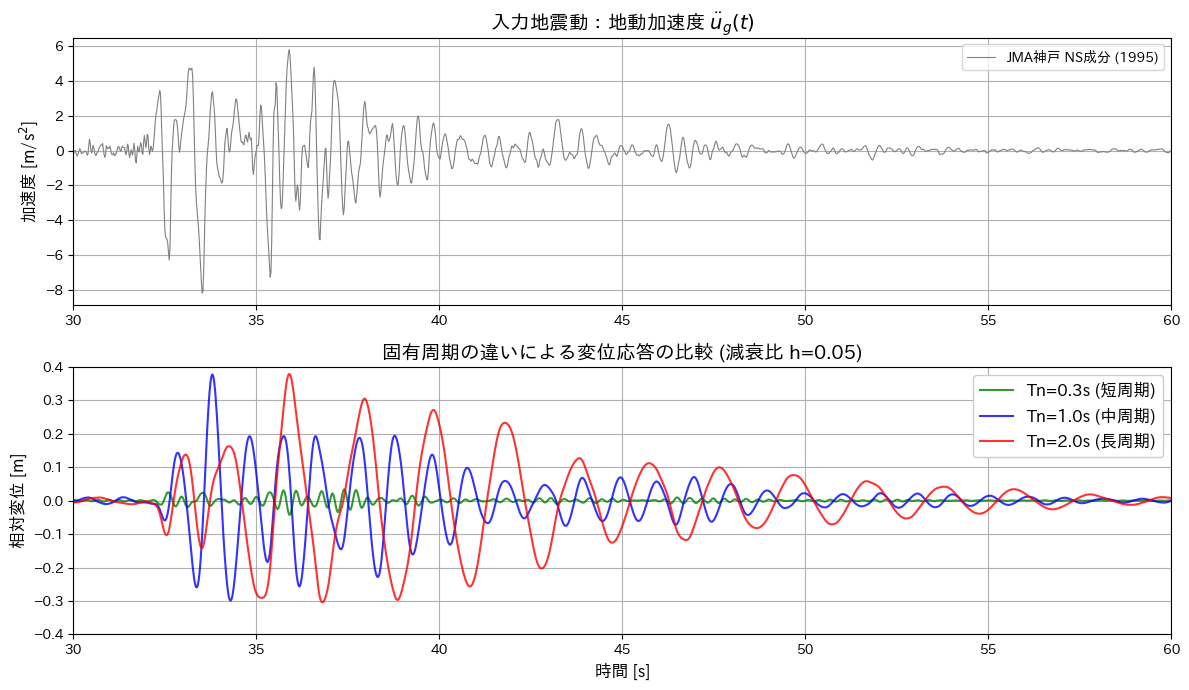

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# -----------------------------------------------------------------
# 1. 地震波データの読み込み関数 (変更なし)
# -----------------------------------------------------------------
def load_jma_kobe_data(filename="1995兵庫県南部地震.csv", component='NS'):
    """
    JMA神戸波のCSVファイルを読み込む
    """
    with open(filename, 'r', encoding='shift_jis') as f:
        for i, line in enumerate(f):
            if i == 3:  # 4行目 (SAMPLING RATE)
                rate_str = line.split(',')[0].split('=')[1]
                dt = 1.0 / float(rate_str.replace('Hz', '').strip())
                break

    data = pd.read_csv(
        filename,
        skiprows=7,
        header=None,
        usecols=[0, 1, 2],
        names=['NS', 'EW', 'UD'],
        encoding='shift_jis'
    )
    data = data.fillna(0)
    ag = data[component].to_numpy(dtype=float)
    return ag, dt

# -----------------------------------------------------------------
# 2. Newmark-β法 汎用ソルバー (変更なし)
# -----------------------------------------------------------------
def newmark_beta(m, c, k, p_force, dt, u0, v0, beta, gamma):
    """
    Newmark-β法（有効剛性法）の汎用ソルバー
    """
    n_steps = len(p_force)
    u = np.zeros(n_steps)
    v = np.zeros(n_steps)
    a = np.zeros(n_steps)

    u[0] = u0
    v[0] = v0
    a[0] = (p_force[0] - c * v[0] - k * u[0]) / m

    a0 = 1.0 / (beta * dt**2)
    a1 = gamma / (beta * dt)
    a2 = 1.0 / (beta * dt)
    a3 = 1.0 / (2.0 * beta) - 1.0
    a4 = gamma / beta - 1.0
    a5 = (dt / 2.0) * (gamma / beta - 2.0)
    a6 = dt * (1.0 - gamma)
    a7 = gamma * dt

    K_hat = k + a0 * m + a1 * c

    for i in range(n_steps - 1):
        P_hat = p_force[i+1] + m * (a0*u[i] + a2*v[i] + a3*a[i]) \
                               + c * (a1*u[i] + a4*v[i] + a5*a[i])

        u[i+1] = P_hat / K_hat
        a[i+1] = a0 * (u[i+1] - u[i]) - a2 * v[i] - a3 * a[i]
        v[i+1] = v[i] + a6 * a[i] + a7 * a[i+1]

    t = np.arange(0, n_steps * dt, dt)
    return t, u, v, a

# -----------------------------------------------------------------
# 3. メイン実行部 (★大幅変更★)
# -----------------------------------------------------------------
if __name__ == "__main__":

    # --- (A) 地震動データの読み込み ---
    try:
        ag, dt = load_jma_kobe_data(filename="1995兵庫県南部地震.csv", component='NS')
        ag = ag / 100
    except FileNotFoundError:
        print("エラー: '1995兵庫県南部地震.csv' が見つかりません。")
        exit()
    except Exception as e:
        print(f"CSVファイルの読み込み中にエラーが発生しました: {e}")
        exit()

    # --- (B) 比較する3つのケースを設定 ---
    cases = [
        {'Tn': 0.3, 'label': 'Tn=0.3s (短周期)', 'color': 'green'},
        {'Tn': 1.0, 'label': 'Tn=1.0s (中周期)', 'color': 'blue'},
        {'Tn': 2.0, 'label': 'Tn=2.0s (長周期)', 'color': 'red'}
    ]
    h = 0.05     # 減衰比は共通 (5%)
    m = 1.0      # 質量も共通

    # Newmark-β法のパラメータ (平均加速度法)
    beta_param = 1.0 / 4.0
    gamma_param = 1.0 / 2.0

    u0 = 0.0
    v0 = 0.0
    p_force = -m * ag # 外力も共通

    # --- (C) グラフ描画の準備 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [1, 1]})

    # --- (D) グラフ1: 入力地震動 (ax1) ---
    ax1.plot(np.arange(len(ag)) * dt, ag, 'gray', linewidth=0.8, label='JMA神戸 NS成分 (1995)')
    ax1.set_title('入力地震動：地動加速度 $\\ddot{u}_g(t)$', fontsize=14)
    ax1.set_ylabel('加速度 [m/s$^2$]', fontsize=12)
    ax1.grid(True)
    ax1.legend(loc='upper right')
    ax1.set_xlim(30, 60) # 地震動の主要部分が見えるように60秒まで表示

    # --- (E) 3ケースのループ計算と重ね書き (ax2) ---
    print(f"解析開始... (減衰比 h={h}, 時間刻み dt={dt}s)")

    for case in cases:
        Tn = case['Tn']
        label = case['label']
        color = case['color']

        # 固有周期から剛性k, 減衰係数cを計算
        wn = 2.0 * np.pi / Tn
        k = wn**2 * m
        c = 2.0 * h * wn * m

        # Newmark-β法で計算
        print(f"  - 計算中: {label} ...")
        t, u, v, a = newmark_beta(m, c, k, p_force, dt, u0, v0, beta_param, gamma_param)

        # 結果を重ね書きプロット
        ax2.plot(t, u, color=color, linewidth=1.5, alpha=0.8, label=label)

    print("全ケース解析完了。")

    # --- (F) グラフ2の仕上げ (ax2) ---
    ax2.set_title(f'固有周期の違いによる変位応答の比較 (減衰比 h={h})', fontsize=14)
    ax2.set_xlabel('時間 [s]', fontsize=12)
    ax2.set_ylabel('相対変位 [m]', fontsize=12)
    ax2.grid(True)
    ax2.legend(fontsize=12, loc='upper right', framealpha=1.0)
    ax2.set_xlim(30, 60) # 横軸を地震動と同じ範囲に
    ax2.set_ylim(-.4, .4)

    plt.tight_layout()
    plt.show()